<a href="https://colab.research.google.com/github/sheikmohdimran/Experiments_2019/blob/master/Stain_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://github.com/wanghao14/Stain_Normalization/raw/master/data/i1.png
!wget https://github.com/wanghao14/Stain_Normalization/raw/master/data/i2.png
!wget https://github.com/wanghao14/Stain_Normalization/raw/master/data/i3.png
!wget https://github.com/wanghao14/Stain_Normalization/raw/master/data/i4.png
!wget https://github.com/wanghao14/Stain_Normalization/raw/master/data/i5.png
!wget https://github.com/wanghao14/Stain_Normalization/raw/master/data/i6.png
!wget https://github.com/wanghao14/Stain_Normalization/raw/master/data/i7.png
!wget https://github.com/wanghao14/Stain_Normalization/raw/master/data/i8.png
!wget https://github.com/wanghao14/Stain_Normalization/raw/master/data/i9.png

--2019-12-06 16:22:22--  https://github.com/wanghao14/Stain_Normalization/raw/master/data/i1.png
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wanghao14/Stain_Normalization/master/data/i1.png [following]
--2019-12-06 16:22:22--  https://raw.githubusercontent.com/wanghao14/Stain_Normalization/master/data/i1.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5063048 (4.8M) [image/png]
Saving to: ‘i1.png’

i1.png              100%[===================>]   4.83M  --.-KB/s    in 0.09s   

2019-12-06 16:22:22 (56.4 MB/s) - ‘i1.png’ saved [5063048/5063048]

--2019-12-06 16:22:24--  https://github.com/wang

In [3]:
!pip install spams -q

     |████████████████████████████████| 1.9MB 3.5MB/s 


In [0]:
import numpy as np
import cv2 as cv
import spams
import matplotlib.pyplot as plt

def build_stack(tup):
    N = len(tup)
    if len(tup[0].shape) == 3:
        h, w, c = tup[0].shape
        stack = np.zeros((N, h, w, c))
    if len(tup[0].shape) == 2:
        h, w = tup[0].shape
        stack = np.zeros((N, h, w))
    for i in range(N):
        stack[i] = tup[i]
    return stack

def standardize_brightness(I):
    p = np.percentile(I, 90)
    return np.clip(I * 255.0 / p, 0, 255).astype(np.uint8)

def remove_zeros(I):
    mask = (I == 0)
    I[mask] = 1
    return I

def RGB_to_OD(I):
    I = remove_zeros(I)
    return -1 * np.log(I / 255)

def OD_to_RGB(OD):
    return (255 * np.exp(-1 * OD)).astype(np.uint8)

def normalize_rows(A):
    return A / np.linalg.norm(A, axis=1)[:, None]

###

def read_image(path):
    im = cv.imread(path)
    im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    return im

def show(image, now=True, fig_size=(10, 10)):
    """
    Show an image (np.array).
    Caution! Rescales image to be in range [0,1].
    :param image:
    :param now:
    :param fig_size:
    :return:
    """
    image = image.astype(np.float32)
    m, M = image.min(), image.max()
    if fig_size != None:
        plt.rcParams['figure.figsize'] = (fig_size[0], fig_size[1])
    plt.imshow((image - m) / (M - m), cmap='gray')
    plt.axis('off')
    if now == True:
        plt.show()

def notwhite_mask(I, thresh=0.8):
    I_LAB = cv.cvtColor(I, cv.COLOR_RGB2LAB)
    L = I_LAB[:, :, 0] / 255.0
    return (L < thresh)


def get_concentrations(I, stain_matrix, lamda=0.01):
    OD = RGB_to_OD(I).reshape((-1, 3))
    return spams.lasso(OD.T, D=stain_matrix.T, mode=2, lambda1=lamda, pos=True).toarray().T
	
def get_stain_matrix(I, threshold=0.8, lamda=0.1):
    mask = notwhite_mask(I, thresh=threshold).reshape((-1,))
    OD = RGB_to_OD(I).reshape((-1, 3))
    OD = OD[mask]
    dictionary = spams.trainDL(OD.T, K=2, lambda1=lamda, mode=2, modeD=0, posAlpha=True, posD=True, verbose=False).T
    if dictionary[0, 0] < dictionary[1, 0]:
        dictionary = dictionary[[1, 0], :]
    dictionary = normalize_rows(dictionary)
    return dictionary


###

class Normalizer(object):
    def __init__(self):
        self.stain_matrix_target = None

    def fit(self, target):
        target = standardize_brightness(target)
        self.stain_matrix_target = get_stain_matrix(target)

    def target_stains(self):
        return OD_to_RGB(self.stain_matrix_target)

    def transform(self, I):
        I = standardize_brightness(I)
        stain_matrix_source = get_stain_matrix(I)
        source_concentrations = get_concentrations(I, stain_matrix_source)
        return (255 * np.exp(-1 * np.dot(source_concentrations, self.stain_matrix_target).reshape(I.shape))).astype(
            np.uint8)

###

def patch_grid(ims, width=5, sub_sample=None, rand=False, save_name=None):
    """
    Display a grid of patches
    :param ims:
    :param width:
    :param sub_sample:
    :param rand:
    :return:
    """
    N0 = np.shape(ims)[0]
    if sub_sample == None:
        N = N0
        stack = ims
    elif sub_sample != None and rand == False:
        N = sub_sample
        stack = ims[:N]
    elif sub_sample != None and rand == True:
        N = sub_sample
        idx = np.random.choice(range(N), sub_sample, replace=False)
        stack = ims[idx]
    height = np.ceil(float(N) / width).astype(np.uint16)
    plt.rcParams['figure.figsize'] = (18, (18 / width) * height)
    plt.figure()
    for i in range(N):
        plt.subplot(height, width, i + 1)
        im = stack[i]
        show(im, now=False, fig_size=None)
    if save_name != None:
        plt.savefig(save_name)
    plt.show()


In [0]:
import cProfile

In [0]:
i1=read_image('i1.png')
i2=read_image('i2.png')
i3=read_image('i3.png')
i4=read_image('i4.png')
i5=read_image('i5.png')
i6=read_image('i6.png')
i7=read_image('i7.png')
i8=read_image('i8.png')
i9=read_image('i9.png')


In [136]:
%%time
n=Normalizer()
n.fit(i1)
%prun normalized=build_stack((i1,n.transform(i5),n.transform(i6),n.transform(i7),n.transform(i8),n.transform(i9)))

 CPU times: user 35.4 s, sys: 2.51 s, total: 37.9 s
Wall time: 22.1 s


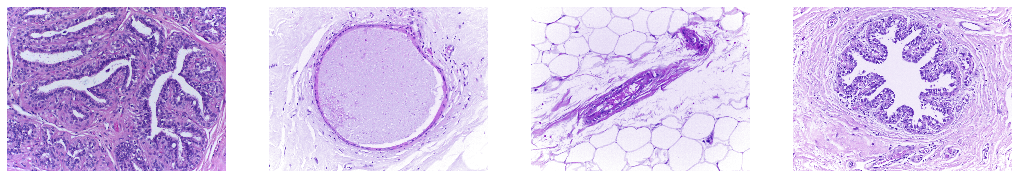

In [8]:
patch_grid(normalized,width=4)